# FORECASTING BUS DEMAND

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from prophet import Prophet

In [3]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all raws
pd.set_option('display.float_format', lambda x: '%.3f' %
              x)
pd.set_option('display.width', 500)

In [4]:
MUNICIPALITY_COUNT = 10
TOTAL_DATA_RAW_COUNT = 13070
TOTAL_DATA_FEATURE_COUNT = 4
EACH_MUNICIPALITY_DATA_RAW_COUNT = TOTAL_DATA_RAW_COUNT/MUNICIPALITY_COUNT
FIRST_DATE = "2017-06-04"
LAST_DATE = "2017-08-19"
TIME_COLUMN_NAME = "timestamp"
MUNICIPALITY_COLUMN_NAME = "municipality_id"
USAGE_COLUMN_NAME = "usage"
TEST_DATA_INDEX_NUMBER = 150

In [5]:
def check_df(dataframe, head=100):
    '''
    Provides general information about the loaded data.

    Parameters
    ----------
    dataframe: dataframe
    head: int

    Notes
    ----------
    The head value is set to a constant 5.
    '''
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("##################### Corr #####################")
    print(dataframe.corr())
    print("##################### Describe #####################")
    print(dataframe.describe())

In [6]:
data = pd.read_csv(r"data/municipality_bus_utilization.csv",header=0)
check_df(data)

##################### Shape #####################
(13070, 4)
##################### Types #####################
timestamp          object
municipality_id     int64
usage               int64
total_capacity      int64
dtype: object
##################### Head #####################
              timestamp  municipality_id  usage  total_capacity
0   2017-06-04 07:59:42                9    454            1332
1   2017-06-04 07:59:42                8    556            2947
2   2017-06-04 07:59:42                4   1090            3893
3   2017-06-04 07:59:42                0    204            2813
4   2017-06-04 07:59:42                7    718            2019
5   2017-06-04 07:59:42                5     70             587
6   2017-06-04 07:59:42                2    273             697
7   2017-06-04 07:59:42                1    129             397
8   2017-06-04 07:59:42                6    597            3113
9   2017-06-04 07:59:42                3    623            1930
10  2017-06-04 08:

### Split dataset by municipality numbers

In [7]:
def sprit_municipality(data,municipality_column_name):
    ''' 
    Allows the given dataset to be sorted by municipality numbers.
    
    Parameters
    ----------
    data: dataframe
    municipality_column_name: str

    Returns
    -------
    df: dataframe
    '''
    df = pd.DataFrame()

    for idx in range(MUNICIPALITY_COUNT):
        each_municipality = data.groupby([municipality_column_name]).get_group(idx)
        df = pd.concat([df,each_municipality], ignore_index=True)
    
    return df

In [8]:
def selecet_max_usage_in_an_hour(data,time_column_name,municipality_column_name,first_character_count=13):
    '''
    It serves to select the one with the maximum value from the measurements within the 1-hour period in the data set.

    Parameters
    ----------
    data: dataframe
    time_column_name: str
    municipality_column_name: str
    first_character_count: int

    Notes
    -----
    first_character_count is set to 13 depending on the time display structure. Because our goal is to determine the measurements within 1 hour.

    Returns
    -------
    data: dataframe
    '''
    data[time_column_name] = data.timestamp.apply(lambda x: x[:first_character_count])
    data = data.groupby([time_column_name,municipality_column_name]).agg({'usage':'max','total_capacity':'max'}).reset_index()
    data.timestamp = pd.to_datetime(data.timestamp)
    # data = sprit_municipality(data,municipality_column_name)

    return data

In [9]:
data = selecet_max_usage_in_an_hour(data,TIME_COLUMN_NAME,MUNICIPALITY_COLUMN_NAME)

In [10]:
check_df(data)

##################### Shape #####################
(6740, 4)
##################### Types #####################
timestamp          datetime64[ns]
municipality_id             int64
usage                       int64
total_capacity              int64
dtype: object
##################### Head #####################
             timestamp  municipality_id  usage  total_capacity
0  2017-06-04 07:00:00                0    204            2813
1  2017-06-04 07:00:00                1    129             397
2  2017-06-04 07:00:00                2    273             697
3  2017-06-04 07:00:00                3    623            1930
4  2017-06-04 07:00:00                4   1090            3893
5  2017-06-04 07:00:00                5     70             587
6  2017-06-04 07:00:00                6    597            3113
7  2017-06-04 07:00:00                7    718            2019
8  2017-06-04 07:00:00                8    556            2947
9  2017-06-04 07:00:00                9    454            133

### Missing Data Detect

In [11]:
temp = data[[TIME_COLUMN_NAME, MUNICIPALITY_COLUMN_NAME]].set_index(TIME_COLUMN_NAME) # All hours and municipality id
rec_hours = temp[temp[MUNICIPALITY_COLUMN_NAME] == 0].loc[FIRST_DATE].index.hour # Working hours. (Between 7 am and 4 pm )

In [12]:
rec_hours

Int64Index([7, 8, 9, 10, 11, 12, 13, 14, 15, 16], dtype='int64', name='timestamp')

In [13]:
def find_missing_dates(data,time_column_name):
    '''
    It allows to detect missing days in the data.

    Parameters
    ----------
    data: dataframe
    time_column_name: str

    Returns
    -------
    missing_dates: list
        List of missing date
    
    '''
    tempdf = data.copy()
    tempdf = tempdf[time_column_name].apply(lambda date: datetime.datetime.strptime(str(date)[:str(date).find(' ')], "%Y-%m-%d"))
    missing_dates = pd.date_range(start=FIRST_DATE, end=LAST_DATE).difference(tempdf.values)
    return missing_dates

In [14]:
def find_missing_hours(data,time_column_name,municipality_column_name):
    '''
    It allows to detect missing hours in the data.

    Parameters
    ----------
    data: dataframe
    time_column_name: str
    municipality_column_name: str

    Returns
    -------
    missing: dict
        dict of missing hours.
    '''
    temp = data[[time_column_name, municipality_column_name]].set_index(time_column_name)
    rec_hours = temp[temp[municipality_column_name] == 0].loc[FIRST_DATE].index.hour

    data = data[[time_column_name, municipality_column_name]].set_index(time_column_name).copy()
    
    missing = {}
    for day in pd.date_range(FIRST_DATE, LAST_DATE):
        hrs = temp[temp[municipality_column_name] == 0].loc[str(day.date())].index.hour.to_list()
        missing_hours = set(rec_hours.to_list()).difference(hrs)
        if (missing_hours != set()):
            missing[str(day.date())] = missing_hours

    return missing

* There are 5 missing days and 47 missing hours.

In [15]:
missing_hours = find_missing_hours(data,TIME_COLUMN_NAME,MUNICIPALITY_COLUMN_NAME)
missing_date = find_missing_dates(data,TIME_COLUMN_NAME)
missing_hours


{'2017-06-07': {7},
 '2017-06-09': {7},
 '2017-06-10': {7},
 '2017-06-11': {7},
 '2017-06-12': {7},
 '2017-06-14': {7},
 '2017-06-15': {7},
 '2017-06-16': {7},
 '2017-06-17': {7},
 '2017-06-18': {7},
 '2017-06-19': {7},
 '2017-06-20': {7, 8, 9, 10, 11, 12, 13, 14, 15, 16},
 '2017-06-21': {7, 8, 9, 10, 11, 12, 13, 14, 15, 16},
 '2017-06-25': {7},
 '2017-06-28': {7},
 '2017-07-01': {7},
 '2017-07-03': {7},
 '2017-07-04': {7},
 '2017-07-05': {7},
 '2017-07-06': {7},
 '2017-07-07': {7},
 '2017-07-09': {7},
 '2017-07-10': {7},
 '2017-07-11': {7},
 '2017-07-12': {7},
 '2017-07-13': {7},
 '2017-07-14': {7},
 '2017-07-16': {7},
 '2017-07-17': {7},
 '2017-07-18': {7},
 '2017-07-20': {7},
 '2017-07-21': {7},
 '2017-07-23': {7},
 '2017-07-24': {7},
 '2017-07-25': {7},
 '2017-07-26': {7},
 '2017-07-27': {7},
 '2017-07-28': {7},
 '2017-07-30': {7},
 '2017-07-31': {7, 8, 9, 10, 11, 12, 13, 14, 15, 16},
 '2017-08-01': {7},
 '2017-08-03': {7, 8, 9, 10, 11, 12, 13, 14, 15, 16},
 '2017-08-04': {7, 8, 9,

### Filling Missing Data

In [16]:
def create_missing_dataframe(missing_hours,time_column_name,municipality_column_name,usage_column_name):    
    missing_dates = []
    for day in pd.date_range(FIRST_DATE, LAST_DATE):
        if (str(day.date()) in missing_hours):
            new_date = [day.replace(hour=hour) for hour in missing_hours[str(day.date())]]
            missing_dates.extend(new_date)

    missing_muni = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] * len(missing_dates)
    missing_dates = sorted(missing_dates*10)
    missing_usage = [np.nan] * len(missing_muni) 
    missing_df = pd.DataFrame(data={time_column_name: missing_dates, 
                                    municipality_column_name: missing_muni, 
                                    usage_column_name: missing_usage})
    
    return missing_df

In [17]:
missing_df = create_missing_dataframe(missing_hours,TIME_COLUMN_NAME,MUNICIPALITY_COLUMN_NAME,USAGE_COLUMN_NAME)
missing_df

,timestamp,municipality_id,usage
0,2017-06-07 07:00:00,0,NaN
1,2017-06-07 07:00:00,1,NaN
2,2017-06-07 07:00:00,2,NaN
3,2017-06-07 07:00:00,3,NaN
4,2017-06-07 07:00:00,4,NaN
5,2017-06-07 07:00:00,5,NaN
6,2017-06-07 07:00:00,6,NaN
7,2017-06-07 07:00:00,7,NaN
8,2017-06-07 07:00:00,8,NaN
9,2017-06-07 07:00:00,9,NaN


In [18]:
def mean_each_hour(data,time_column_name,municipality_column_name,usage_column_name):
    
    temp = data[[time_column_name, municipality_column_name]].set_index(time_column_name)
    rec_hours = temp[temp[municipality_column_name] == 0].loc[FIRST_DATE].index.hour

    means = {}
    for muni in data[municipality_column_name].unique():
        temp = data[data[municipality_column_name] == muni].set_index(time_column_name)
        for hr in rec_hours:
            means[f'{muni}_{hr}'] = np.mean(temp[temp.index.hour == hr][usage_column_name])
    
    return means

In [19]:
means = mean_each_hour(data,TIME_COLUMN_NAME,MUNICIPALITY_COLUMN_NAME,USAGE_COLUMN_NAME)
means

{'0_7': 229.92307692307693,
 '0_8': 310.6666666666667,
 '0_9': 440.52777777777777,
 '0_10': 548.6111111111111,
 '0_11': 620.2222222222222,
 '0_12': 660.4305555555555,
 '0_13': 682.4305555555555,
 '0_14': 686.1111111111111,
 '0_15': 654.5,
 '0_16': 588.5416666666666,
 '1_7': 134.15384615384616,
 '1_8': 161.84722222222223,
 '1_9': 231.05555555555554,
 '1_10': 296.5,
 '1_11': 340.0416666666667,
 '1_12': 359.0833333333333,
 '1_13': 368.25,
 '1_14': 366.40277777777777,
 '1_15': 352.90277777777777,
 '1_16': 323.77777777777777,
 '2_7': 310.3076923076923,
 '2_8': 340.3611111111111,
 '2_9': 416.18055555555554,
 '2_10': 479.90277777777777,
 '2_11': 521.6388888888889,
 '2_12': 555.3333333333334,
 '2_13': 579.1805555555555,
 '2_14': 581.9583333333334,
 '2_15': 554.1111111111111,
 '2_16': 500.4166666666667,
 '3_7': 505.7692307692308,
 '3_8': 689.0,
 '3_9': 966.4583333333334,
 '3_10': 1133.5833333333333,
 '3_11': 1217.8055555555557,
 '3_12': 1273.736111111111,
 '3_13': 1294.4722222222222,
 '3_14': 1

In [20]:
def fill_all_missing_values(data,missing_df,means,time_column_name,municipality_column_name):

    missing_df = missing_df.set_index(time_column_name)
    for muni in data[municipality_column_name].unique():
        for hr in rec_hours:
            missing_df[(missing_df[municipality_column_name] == muni) & (missing_df.index.hour == hr)] = missing_df[(missing_df[municipality_column_name] == muni) & (missing_df.index.hour == hr)].fillna(means[f'{muni}_{hr}'])

    final_df = pd.concat((data.set_index(time_column_name), missing_df))
    final_df = final_df.sort_index()

    return final_df

In [21]:
clean_data = fill_all_missing_values(data,missing_df,means,TIME_COLUMN_NAME,MUNICIPALITY_COLUMN_NAME)
check_df(clean_data)

##################### Shape #####################
(7700, 3)
##################### Types #####################
municipality_id      int64
usage              float64
total_capacity     float64
dtype: object
##################### Head #####################
                     municipality_id    usage  total_capacity
timestamp                                                    
2017-06-04 07:00:00                0  204.000        2813.000
2017-06-04 07:00:00                1  129.000         397.000
2017-06-04 07:00:00                2  273.000         697.000
2017-06-04 07:00:00                3  623.000        1930.000
2017-06-04 07:00:00                4 1090.000        3893.000
2017-06-04 07:00:00                5   70.000         587.000
2017-06-04 07:00:00                6  597.000        3113.000
2017-06-04 07:00:00                7  718.000        2019.000
2017-06-04 07:00:00                8  556.000        2947.000
2017-06-04 07:00:00                9  454.000        1332.000
20

In [22]:
def save_clean_data_as_csv(clean_data,municipality_column_name):

    for muni in clean_data[municipality_column_name].unique():  
        clean_data[clean_data[municipality_column_name] == muni].to_csv(f'data/preprocessed/municipality_{muni}.csv', index=True)

In [23]:
save_clean_data_as_csv(clean_data,MUNICIPALITY_COLUMN_NAME)

### Fit Model and Predict

In [78]:
def prophet_model_predict_and_plot(municipality_id):

    data_municipality_0 = pd.read_csv(f'data/preprocessed/municipality_{municipality_id}.csv',header=0).drop('municipality_id', axis=1)
    data_municipality_0['timestamp'] = data_municipality_0['timestamp'].apply(lambda date: datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S"))
    data_municipality_0 = data_municipality_0.drop(["total_capacity"],axis=1)

    data_municipality_0.columns = ["ds","y"]

    train_data = data_municipality_0.drop(data_municipality_0.index[-TEST_DATA_INDEX_NUMBER:])
    test_data = data_municipality_0.loc[data_municipality_0.index[-TEST_DATA_INDEX_NUMBER:]]

    model = Prophet()
    model.fit(train_data)

    test_result = model.predict(test_data)

    fig, ax = plt.subplots(figsize=(10, 5))
    fig = model.plot(test_result, ax=ax)
    ax.set_title(f'Prophet Forecast {municipality_id}')

    fig = model.plot_components(test_result)
    plt.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

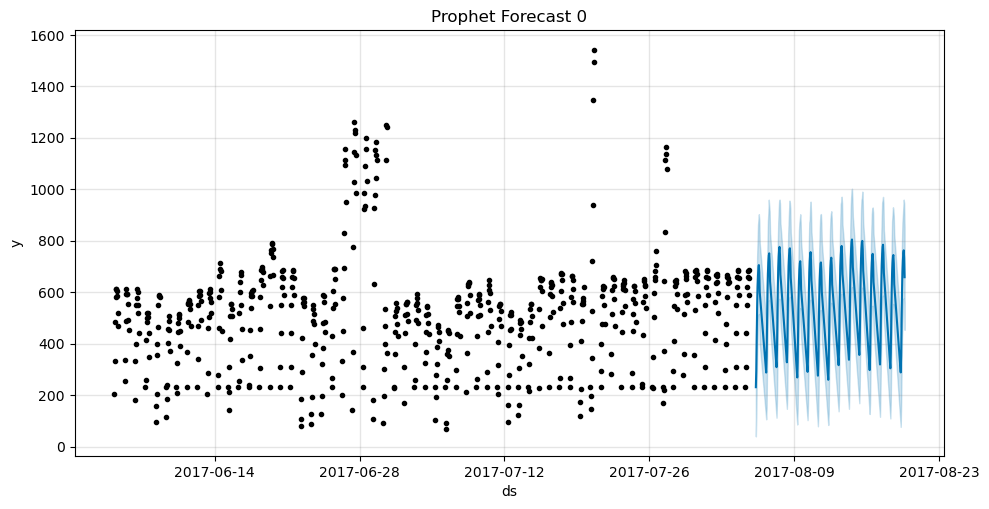

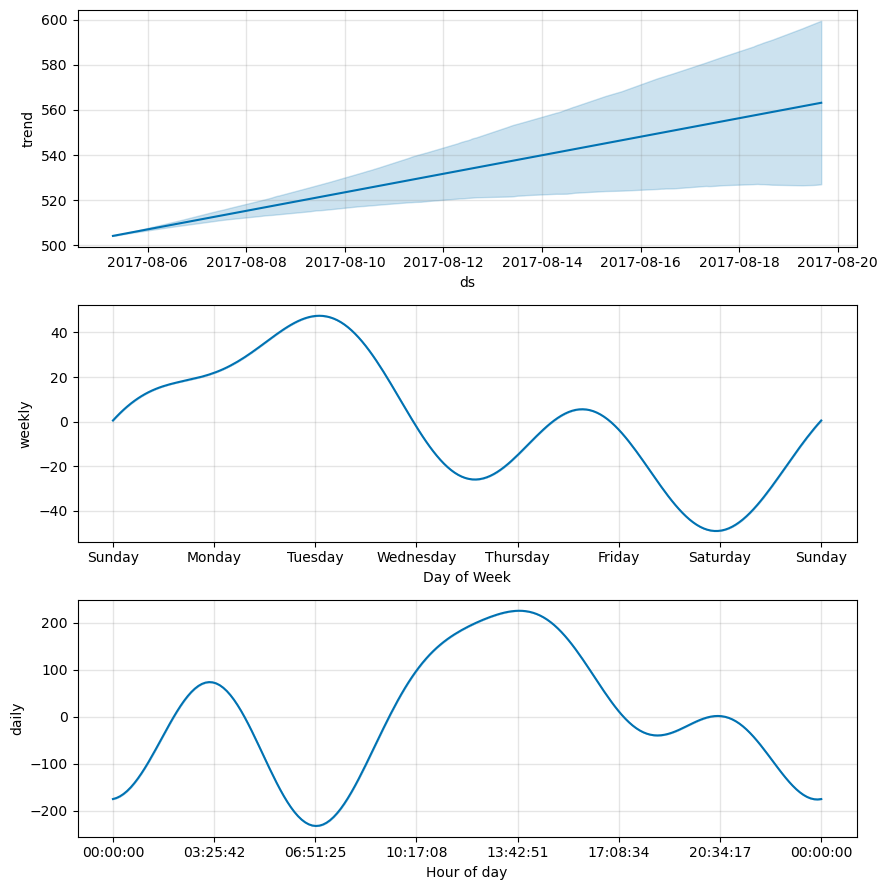

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

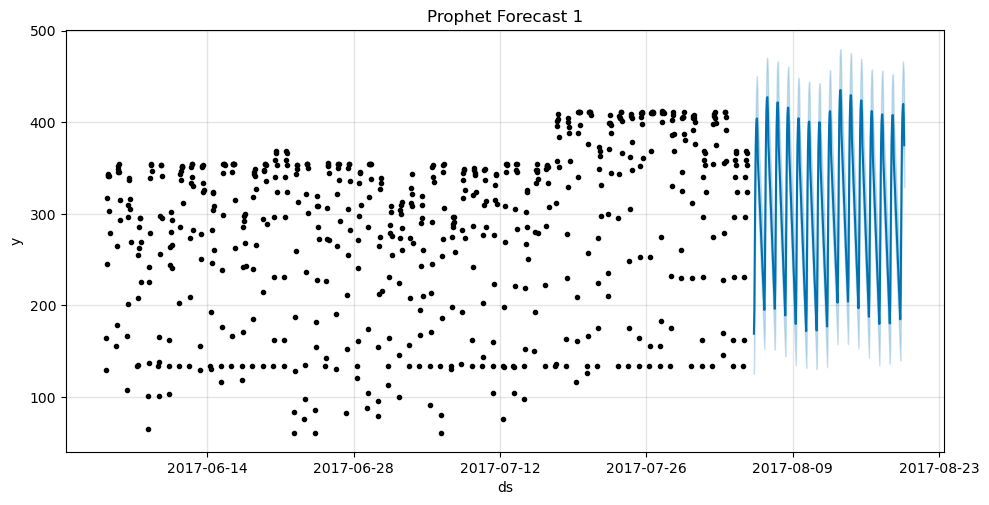

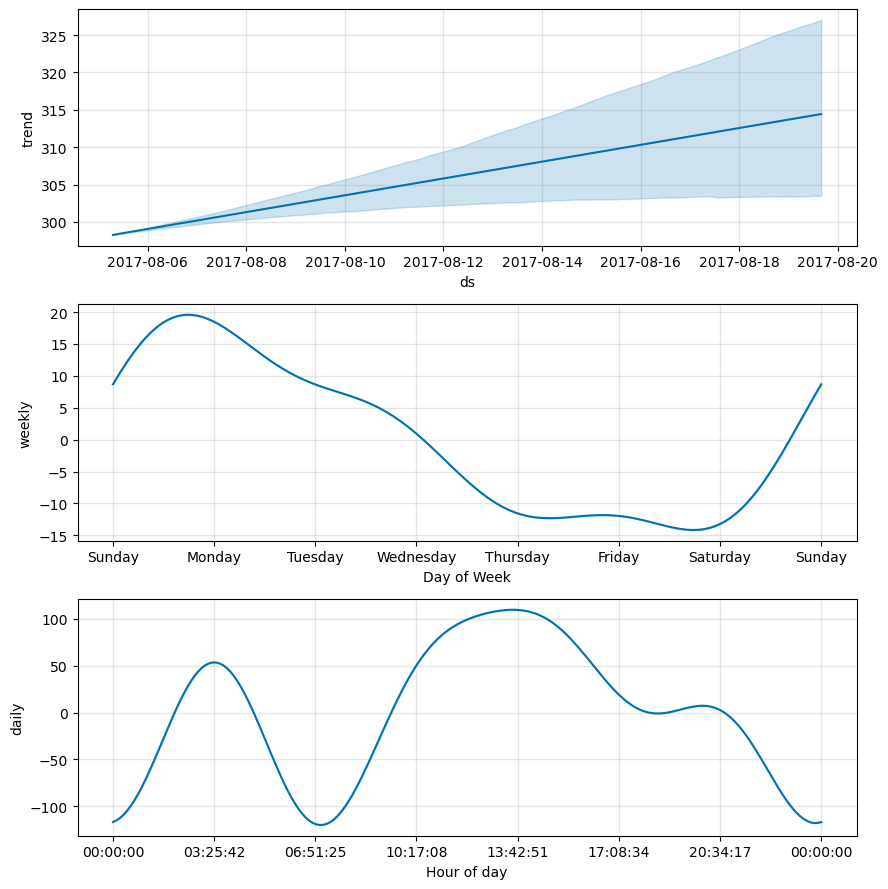

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

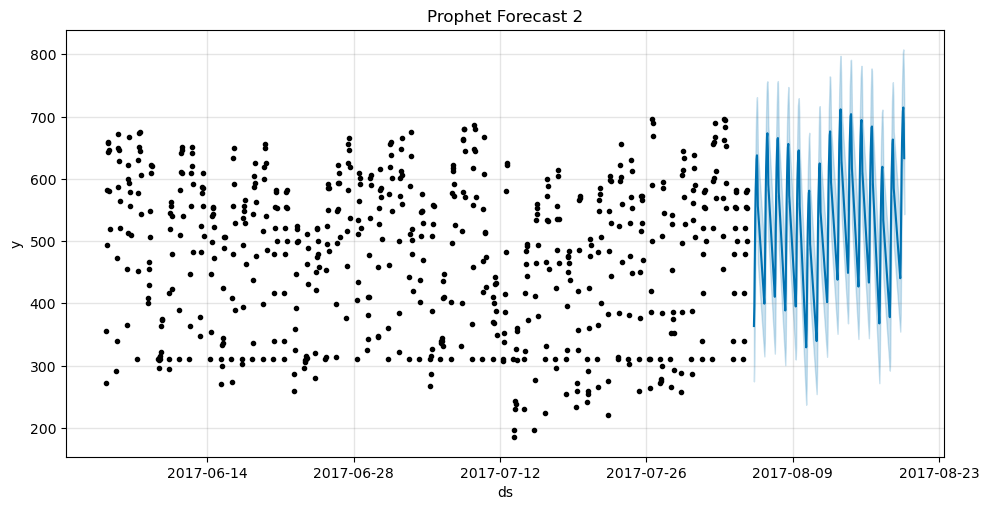

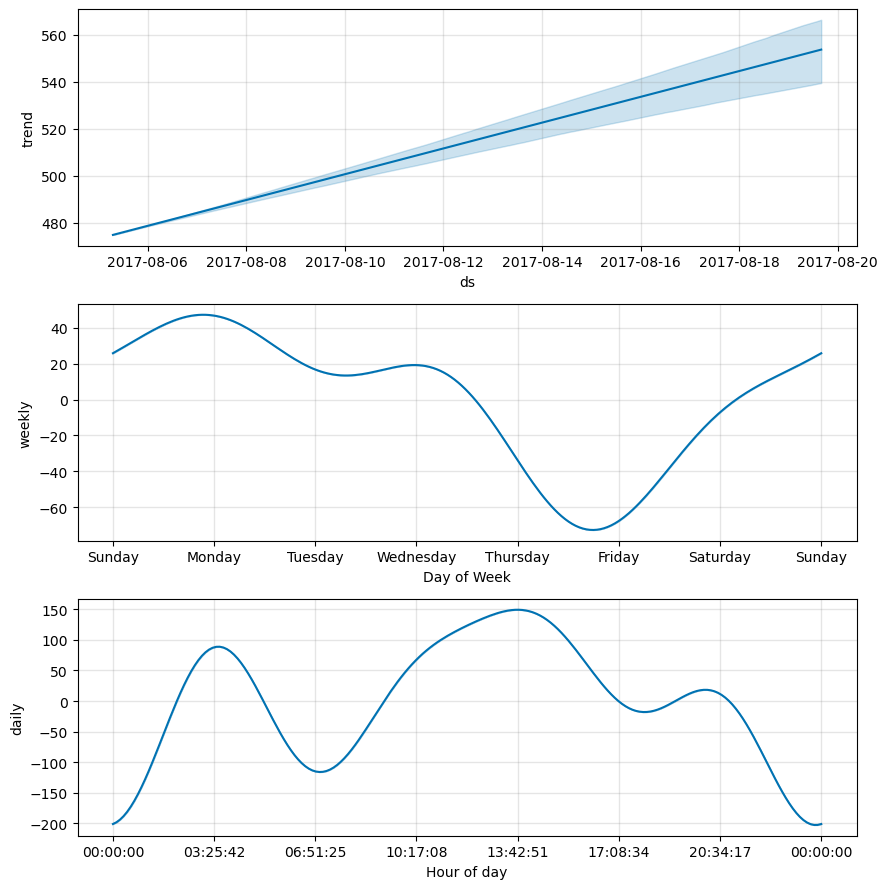

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

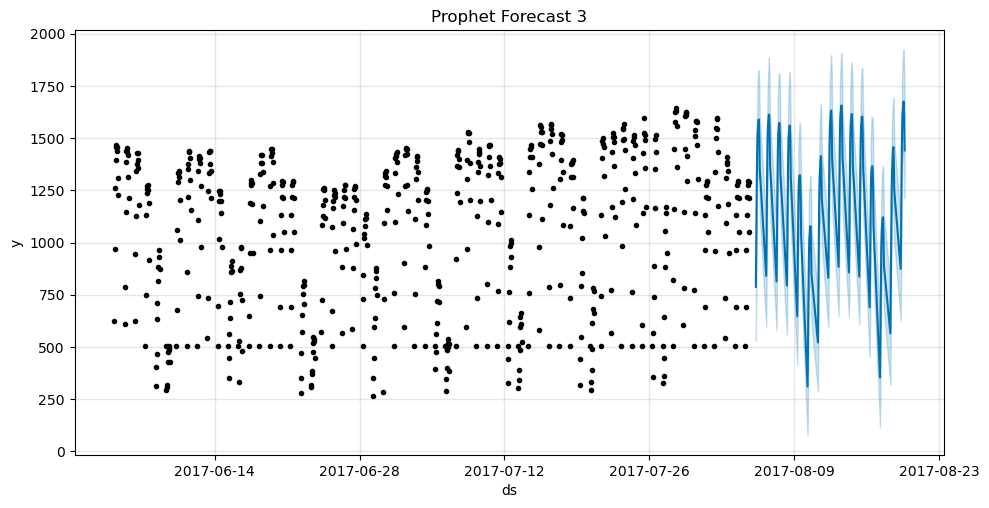

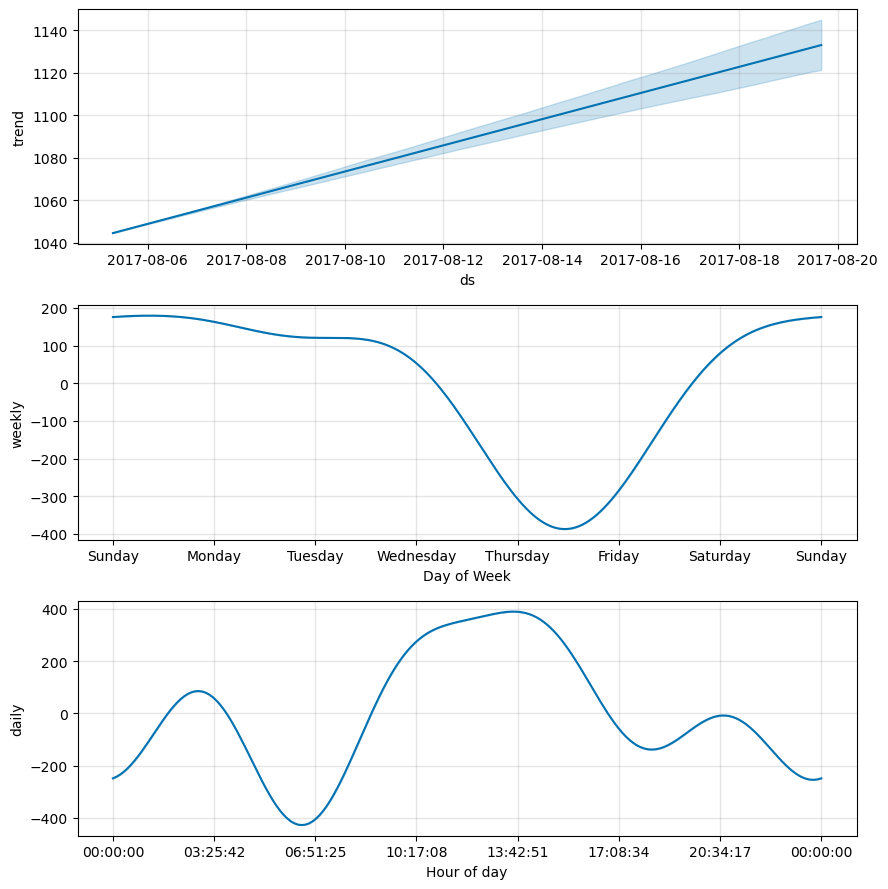

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

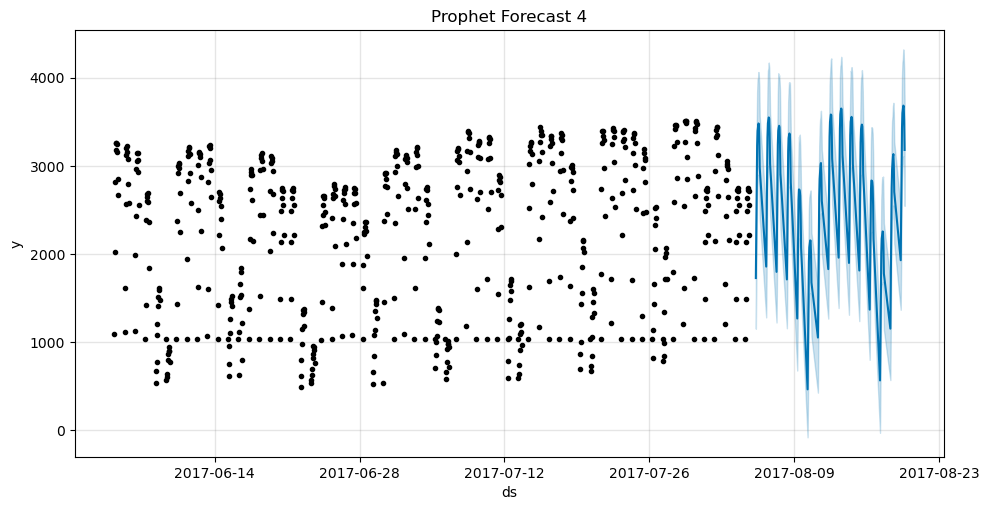

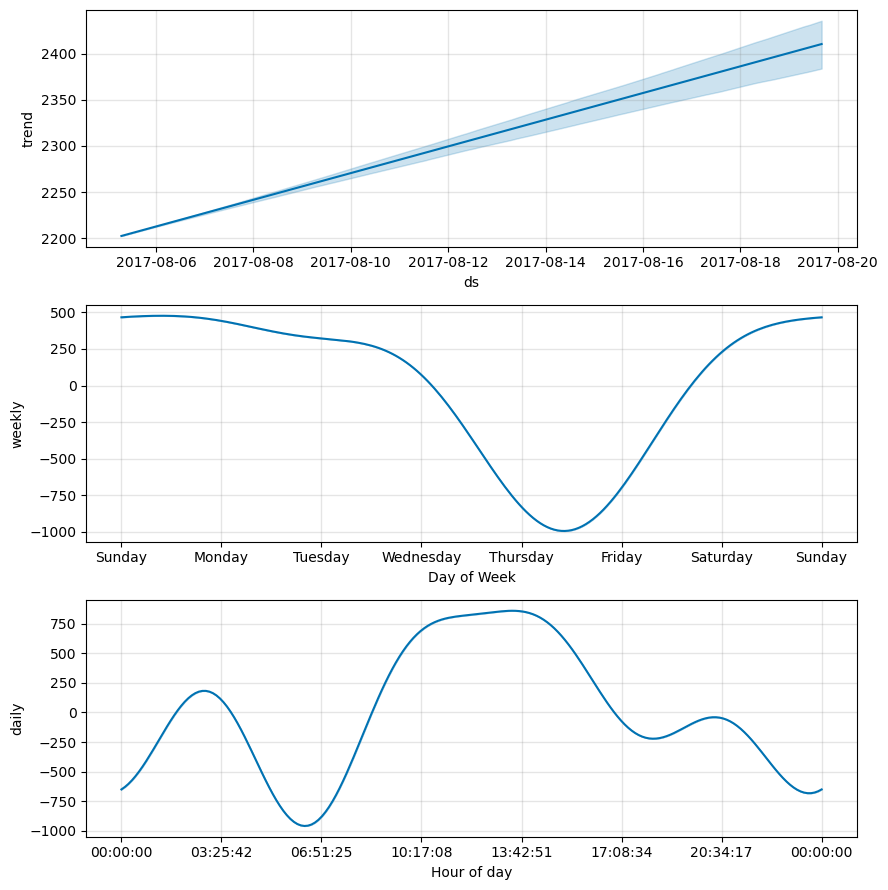

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

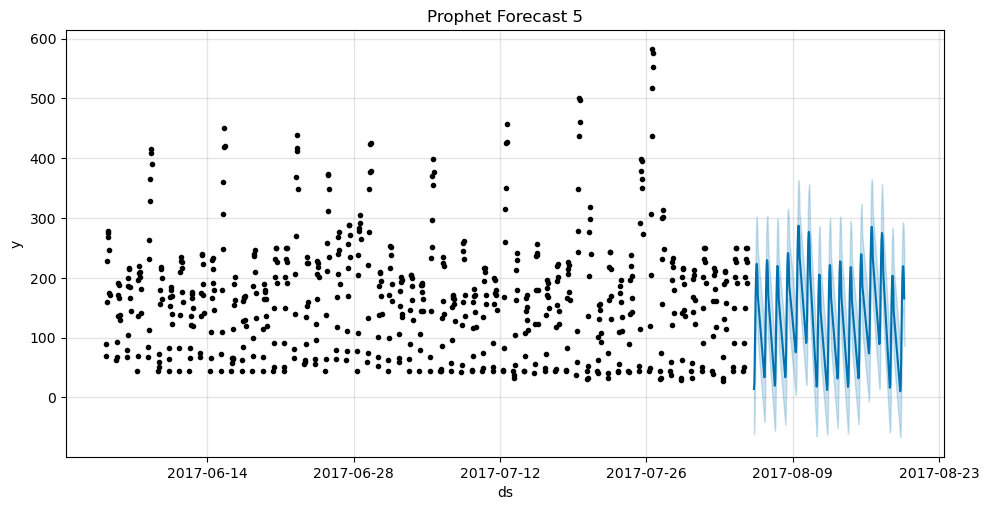

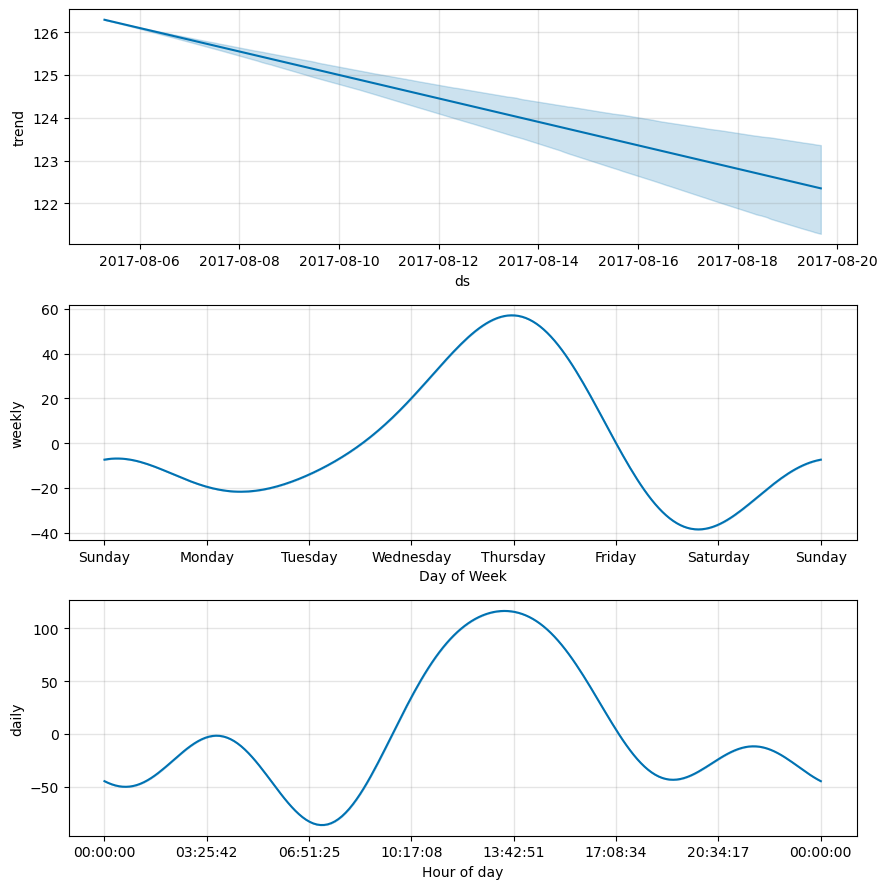

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

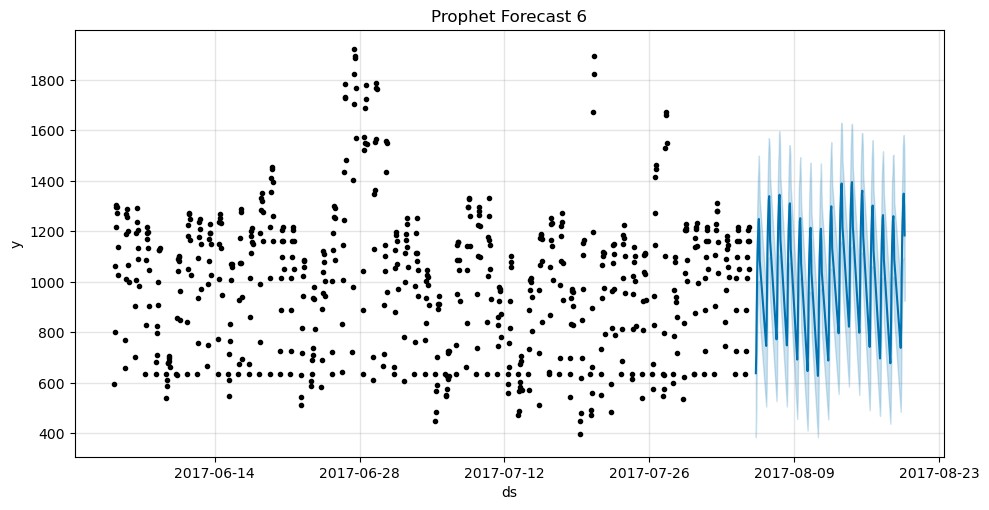

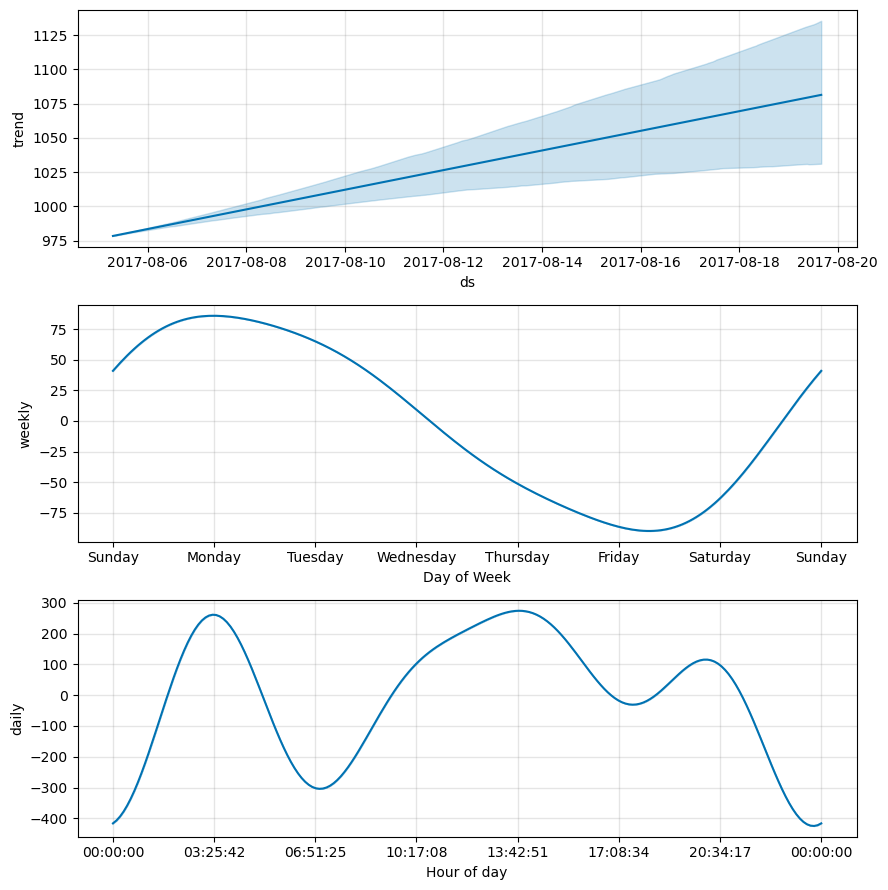

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

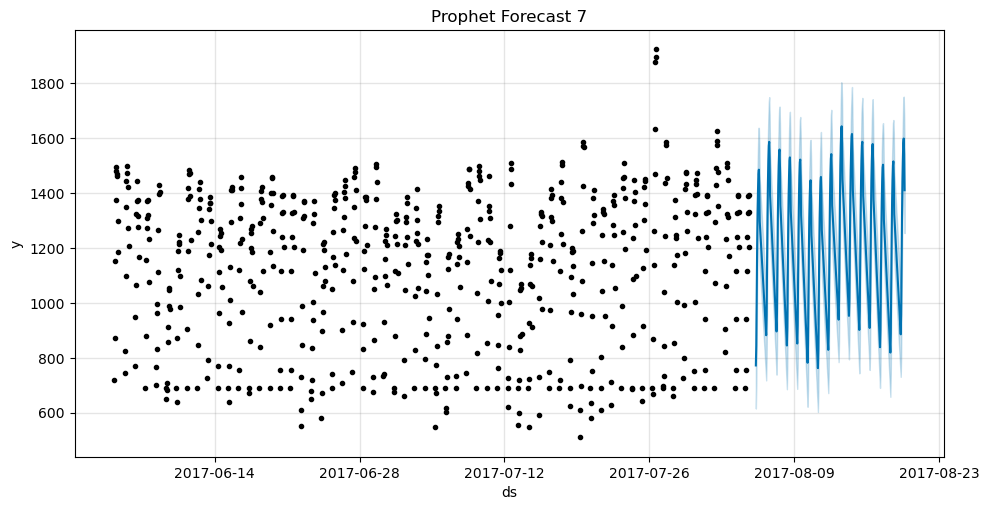

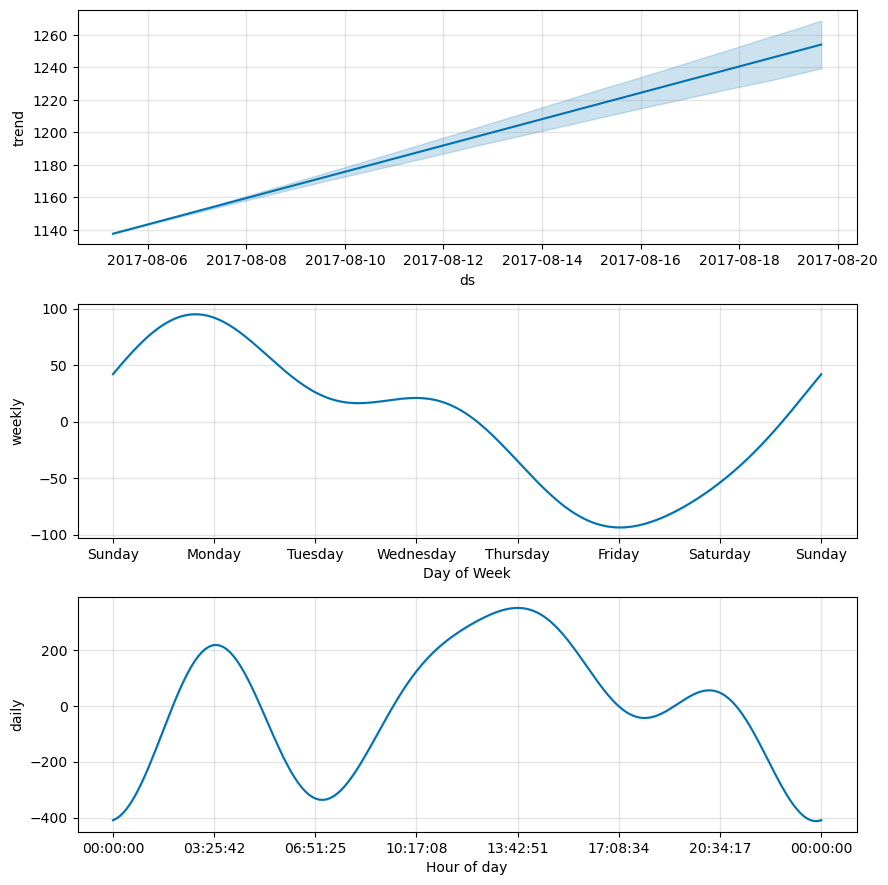

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

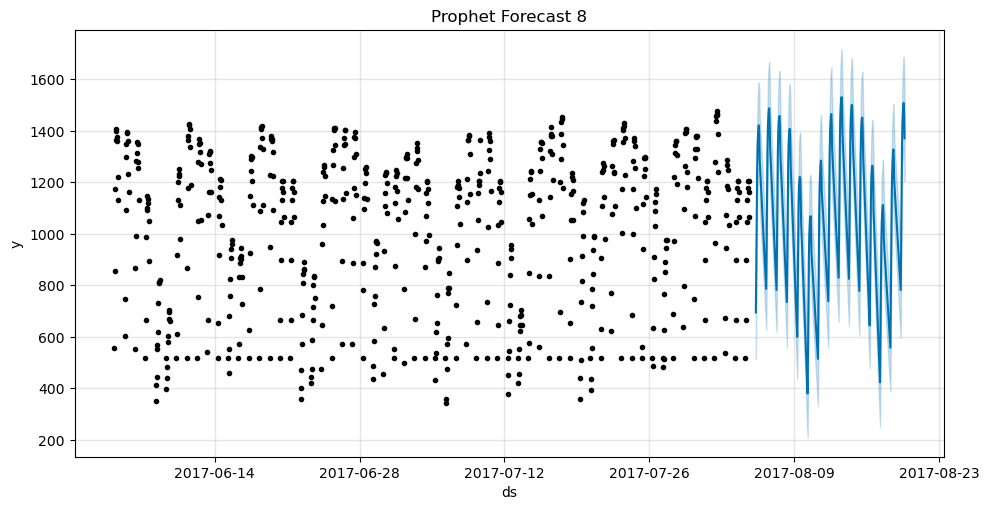

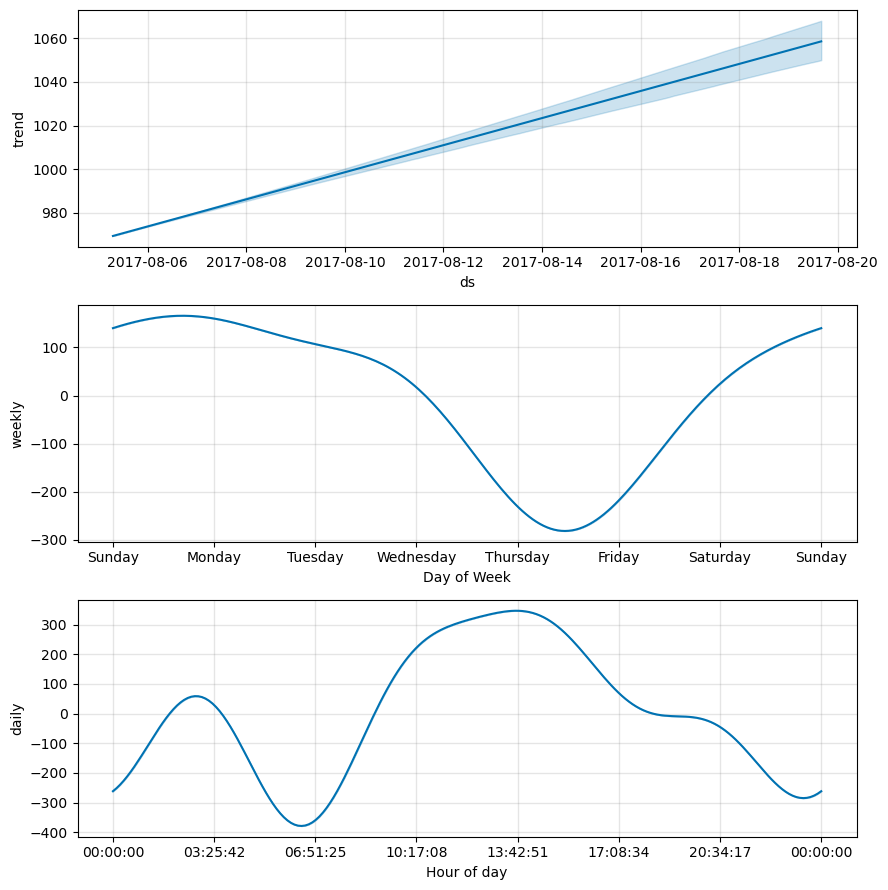

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

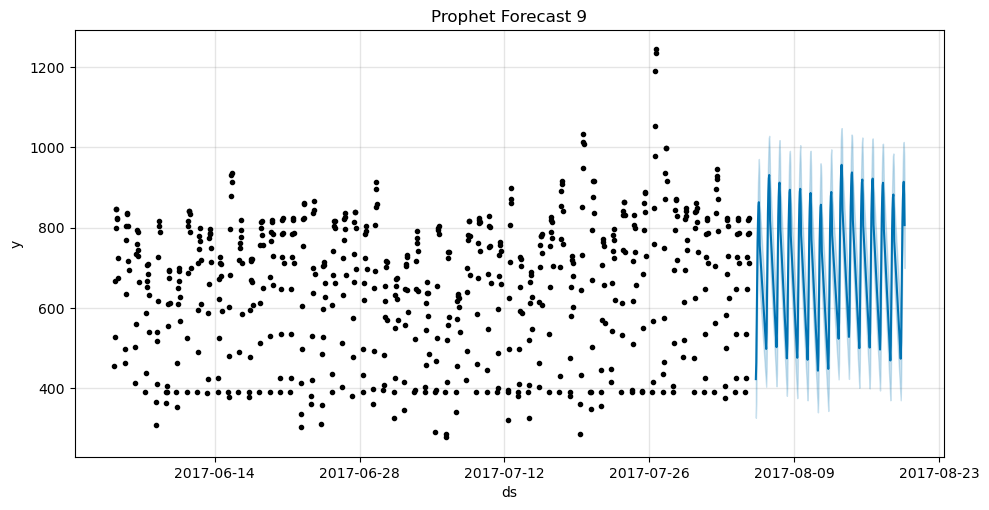

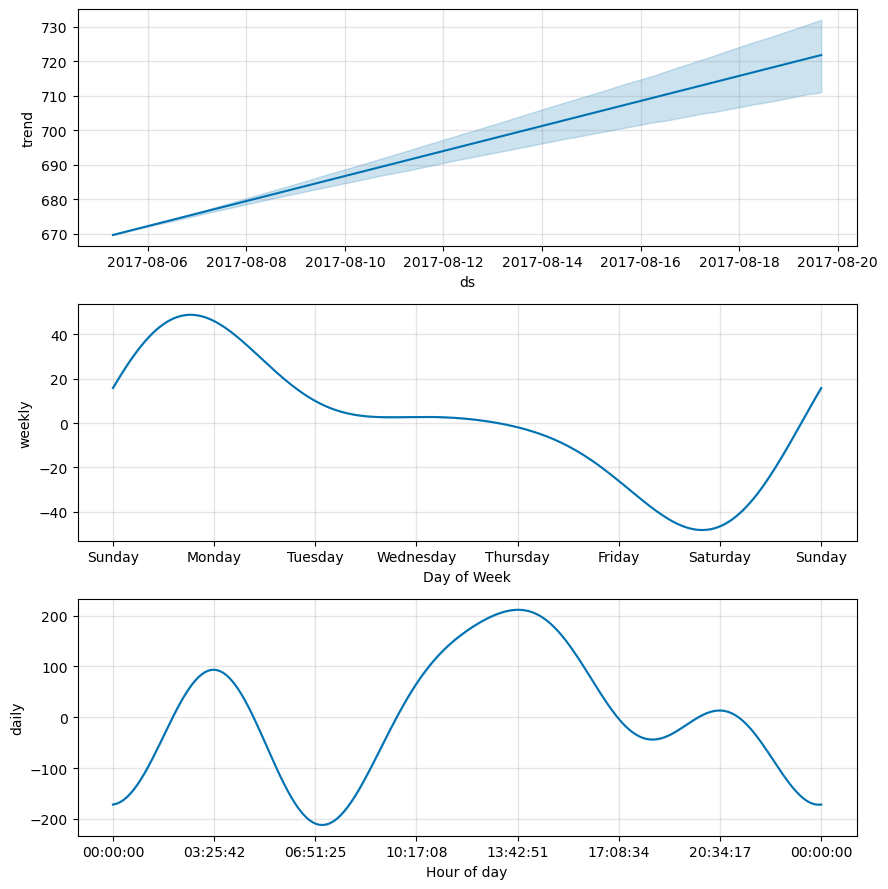

[None, None, None, None, None, None, None, None, None, None]

In [80]:
[prophet_model_predict_and_plot(i) for i in range(10)]

In [ ]:
# TODO: Add performance metrics